<a href="https://colab.research.google.com/github/mohamed46941/butterflies-classification/blob/main/butterflies_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("phucthaiv02/butterfly-image-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/butterfly-image-classification


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [ ]:
import os
import pandas as pd

In [ ]:
os.listdir(path)

['Training_set.csv', 'Testing_set.csv', 'test', 'train']

In [ ]:
train_dir=path+'/train'
test_dir=path+'/test'

In [ ]:
train_df=pd.read_csv(path+'/Training_set.csv')
test_df=pd.read_csv(path+'/Testing_set.csv')

In [ ]:
train_df.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [ ]:
train_df.label.nunique()

75

In [ ]:
import cv2
import numpy as np
from tqdm import tqdm

In [ ]:
labels=[]
imgs=[]
for x, y in tqdm(zip(train_df['filename'], train_df['label'])):
     img=cv2.imread(os.path.join(path+'/train',x))
     img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
     img=cv2.resize(img,(100,100))
     imgs.append(img)
     labels.append(y)
imgs=np.array(imgs)
labels=np.array(labels)

6499it [01:02, 103.75it/s]


In [ ]:
imgs_test=[]
for x in tqdm(test_df['filename']):
     img=cv2.imread(os.path.join(path+'/test',x))
     img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
     img=cv2.resize(img,(100,100))
     imgs_test.append(img)
img_tests=np.array(imgs_test)

100%|██████████| 2786/2786 [00:26<00:00, 107.03it/s]


In [ ]:
import tensorflow as tf

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [ ]:
le = LabelEncoder()
labels_int = le.fit_transform(labels)

In [ ]:
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_temp, y_train, y_temp = train_test_split(
    imgs, labels_int,
    test_size=0.2,
    random_state=42,
    stratify=labels_int
)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp,
    test_size=0.5,
    random_state=42)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)
val_test_datagen = ImageDataGenerator(rescale=1./255)



In [ ]:
train_generator = train_datagen.flow(
    x_train, y_train,
    batch_size=32,
    shuffle=True
)
val_generator = val_test_datagen.flow(
    x_val, y_val,
    batch_size=32,
    shuffle=False
)
test_generator = val_test_datagen.flow(
    x_test, y_test,
    batch_size=32,
    shuffle=False
)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
classes = np.unique(y_train)
cw = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight = dict(zip(classes, cw))

In [ ]:
model=keras.models.Sequential([
    keras.applications.DenseNet121(input_shape=(100,100,3),include_top=False, weights='imagenet'),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(512,activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(75,activation='softmax')
])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.layers[0].trainable = True
for layer in model.layers[0].layers[:300]:
    layer.trainable = False

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 3, 3, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 75)             │         9,675 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,640,203 (29.15 MB)

 Trainable params: 3,490,827 (13.32 MB)

 Non-trainable params: 4,149,376 (15.83 MB)

In [ ]:
history=model.fit(
    train_generator,
    validation_data=val_generator,
    class_weight=class_weight,
    epochs=100,
    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 152s 497ms/step - accuracy: 0.0136 - loss: 5.1478 - val_accuracy: 0.0138 - val_loss: 4.7028
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.0229 - loss: 4.8098 - val_accuracy: 0.0385 - val_loss: 4.4411
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.0457 - loss: 4.5026 - val_accuracy: 0.0831 - val_loss: 4.1560
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.0786 - loss: 4.2202 - val_accuracy: 0.1215 - val_loss: 3.8447
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.1072 - loss: 3.9933 - val_accuracy: 0.1738 - val_loss: 3.5498
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.1458 - loss: 3.7252 - val_accuracy: 0.2415 - val_loss: 3.2759
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.2051 - loss: 3.4636 - val_accuracy: 0.2923 - val_loss: 3.0332
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.2257 

In [ ]:
history.history

{'accuracy': [0.015195230022072792,
  0.0301981158554554,
  0.0511636845767498,
  0.08617042005062103,
  0.12233121693134308,
  0.16330063343048096,
  0.2152336984872818,
  0.2454318106174469,
  0.28659358620643616,
  0.3160223066806793,
  0.35256779193878174,
  0.3739180564880371,
  0.4171956181526184,
  0.4608578681945801,
  0.49509522318840027,
  0.517214834690094,
  0.5293325781822205,
  0.5499134659767151,
  0.5793421864509583,
  0.5972302556037903,
  0.6206963062286377,
  0.6230044364929199,
  0.6558953523635864,
  0.658588171005249,
  0.6797460913658142,
  0.688016951084137,
  0.7122523784637451,
  0.7199461460113525,
  0.731871485710144,
  0.7389882802963257,
  0.7470667362213135,
  0.7541834712028503,
  0.7718791961669922,
  0.7703404426574707,
  0.7816888093948364,
  0.7832275629043579,
  0.7951529026031494,
  0.7974610328674316,
  0.8109251856803894,
  0.8161184787750244,
  0.8255433440208435,
  0.8226581811904907,
  0.8276591897010803,
  0.8359299898147583,
  0.840161561965

In [ ]:
model.evaluate(test_generator)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9139 - loss: 0.3593


[0.39448651671409607, 0.9030769467353821]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

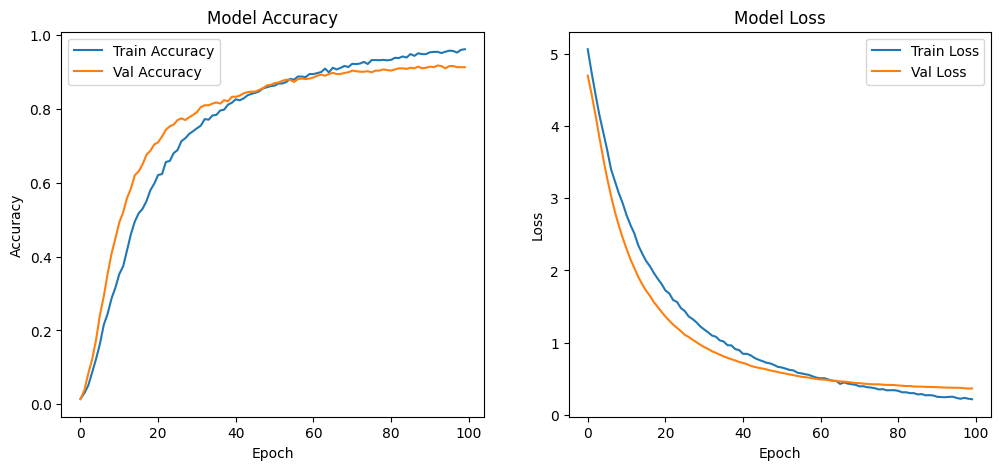

In [ ]:
def plot_history(history):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

plot_history(history)

In [ ]:
img_array = img_tests / 255.0

In [ ]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))


21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 677ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      1.00      1.00        10
           2       0.86      1.00      0.92         6
           3       1.00      1.00      1.00         7
           4       0.90      1.00      0.95         9
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00         8
           7       0.86      0.86      0.86         7
           8       0.75      1.00      0.86         9
           9       0.80      0.80      0.80         5
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         8
          12       1.00      0.89      0.94         9
          13       0.70      1.00      0.82         7
          14       1.00      1.00      1.00         2
          15       1.00      0.88      0.93         8
          16    